# IMU noise characterization using Allan deviation

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Few notes:

### TODO

- add header when saving the imu data, handle the reader here and get the sampl freq from it
- save figure to csv

In [29]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
PATH2FILE = HOME + '/Data/Drones/IMU/'
MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_90mn_SR250_yUp' 
# old name: 'OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp'
CSV_FILENAME = PATH2FILE + MEAS_FILENAME_NO_EXT + '.csv' 
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'

# CSV_FILENAME = HOME+'/Data/Drones/IMU/OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp.csv'
# CSV_FILENAME = HOME+'/Data/Drones/IMU/oak_BNO086_60mn_gyroSR400_accSR500_xDown.csv'
FS = 250  # Sample rate [Hz] # this is obtained from the measured data
ANGLE_UNIT_FOR_NOISE = 'rad' # or 'deg'
VELOCITY_UNIT_FOR_NOISE = 'm/s' # or e.g. 'cm/s'
ACCELERATION_UNIT_FOR_NOISE = 'm/s²' # or 'g'
ACCELERATION_UNIT = 'm/s²' # or 'g'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram
LOAD_SAMPLE = 'all'
SAVE_FIG = True
FIG_FMT = 'svg'

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def fitfunc(x, a, b):
    return a*x + b


In [30]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [4]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [16]:
if ANGLE_UNIT_FOR_NOISE == 'deg':
    gx = gx * (180.0 / np.pi)  # [deg/s]
    gy = gy * (180.0 / np.pi)
    gz = gz * (180.0 / np.pi)


In [5]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 1350000


In [6]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    """Compute the Allan deviation (sigma) of time-series data.

    Algorithm obtained from Mathworks:
    https://www.mathworks.com/help/fusion/ug/inertial-sensor-noise-analysis-using-allan-variance.html

    Args
    ----
        dataArr: 1D data array
        fs: Data sample frequency in Hz
        maxNumM: Number of output points

    Returns
    -------
        (taus, allanDev): Tuple of results
        taus (numpy.ndarray): Array of tau values
        allanDev (numpy.ndarray): Array of computed Allan deviations
    """
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )

    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))



In [7]:
# Calculate gyro angles
thetax = np.cumsum(gx) * TS  # deg or rad depending on ANGLE_UNIT_FOR_NOISE
thetay = np.cumsum(gy) * TS
thetaz = np.cumsum(gz) * TS

# Compute Allan deviations
Mnb = 200 # for noise analysis
(taux, adx) = AllanDeviation(thetax, FS, maxNumM=Mnb)
(tauy, ady) = AllanDeviation(thetay, FS, maxNumM=Mnb)
(tauz, adz) = AllanDeviation(thetaz, FS, maxNumM=Mnb)


In [8]:
# Plot data on log-scale
def plot_allan_gyro(taus,adevs):
    adevfig,adevaxis=plt.subplots(1,figsize=(12, 6))
    adevaxis.set_title('Gyro Allan Deviations')
    adev_lbl = ('gx','gy','gz')
    curve_color = ('r','g','b')
    for i in range(3):
        adevaxis.plot(taus[i], adevs[i], curve_color[i], label=adev_lbl[i])
        # adevaxis.plot(tauy[0], ady, 'g',label='gy')
        # adevaxis.plot(tauz, adz,'b', label='gz')
    adevaxis.set_xlabel(r'$\tau$ [sec]')
    adevaxis.set_ylabel(f'Deviation ({ANGLE_UNIT_FOR_NOISE}/s)')
    adevaxis.grid(True, which="both", ls="-", color='0.65')
    adevaxis.legend()
    adevaxis.set_xscale('log')
    adevaxis.set_yscale('log')
    return adevfig,adevaxis

In [9]:
# Plot data on log-scale
def plot_allan_accel(taus,adevs):
    adevfig,adevaxis=plt.subplots(1,figsize=(12, 6))
    adevaxis.set_title('Accelerometer Allan Deviations')
    adev_lbl = ('ax','ay','az')
    curve_color = ('r','g','b')
    for i in range(3):
        adevaxis.plot(taus[i], adevs[i], curve_color[i], label=adev_lbl[i])
        # adevaxis.plot(tauy[0], ady, 'g',label='gy')
        # adevaxis.plot(tauz, adz,'b', label='gz')
    adevaxis.set_xlabel(r'$\tau$ [sec]')
    adevaxis.set_ylabel(f'Deviation ({ACCELERATION_UNIT})')
    adevaxis.grid(True, which="both", ls="-", color='0.65')
    adevaxis.legend()
    adevaxis.set_xscale('log')
    adevaxis.set_yscale('log')
    return adevfig,adevaxis

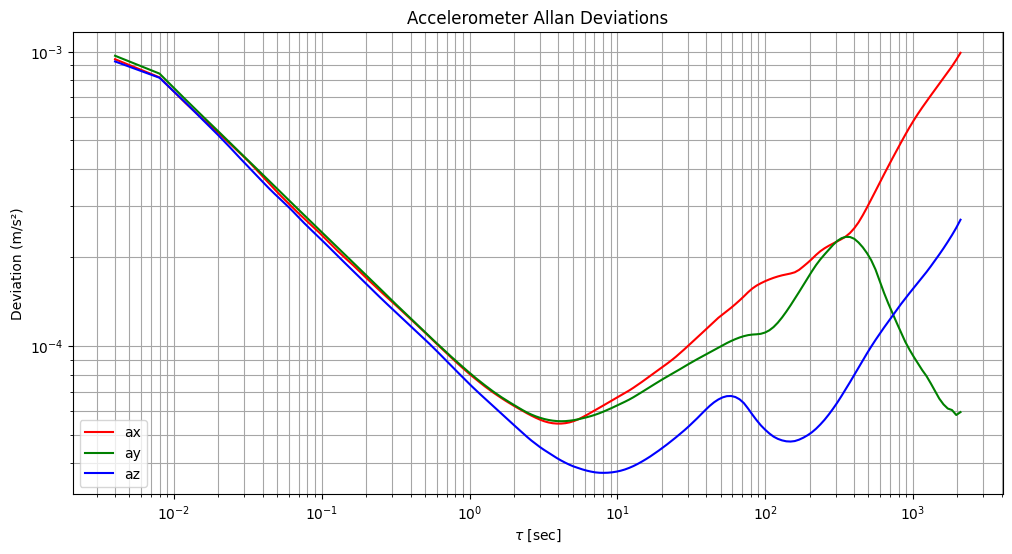

In [21]:
accel_taus = (taux,tauy,tauz)
accel_adevs = (adx,ady,adz)
afig,aaxis=plot_allan_accel(accel_taus, accel_adevs)

In [31]:
if SAVE_FIG:
    # plt.figsave(f'{MEAS_FILENAME}.{FIG_FMT}')
    afig.savefig(f'{MEAS_FILENAME_NO_EXT}.{FIG_FMT}')

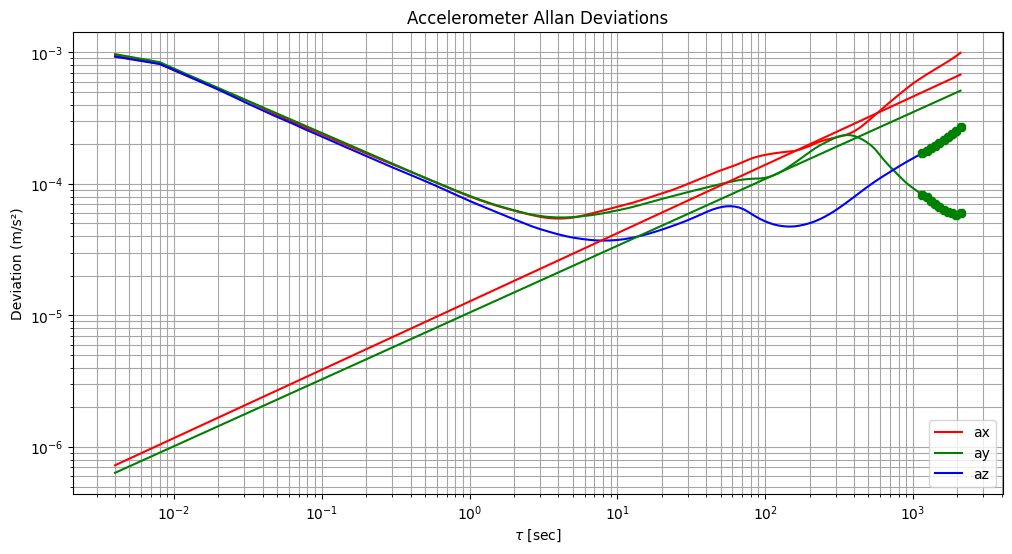

In [32]:
aaxis.plot(taux,rw_fit_x(taux),'r')
aaxis.plot(tauy,rw_fit_y(tauy),'g')
aaxis.plot(tauy[-10:],ady[-10:],'g8')
aaxis.plot(tauz[-10:],adz[-10:],'g8')
# afig.figsave(f'{MEAS_FILENAME}.{FIG_FMT}')
afig

In [46]:
gyro_taus = (taux,tauy,tauz)
gyro_adevs = (adx,ady,adz)

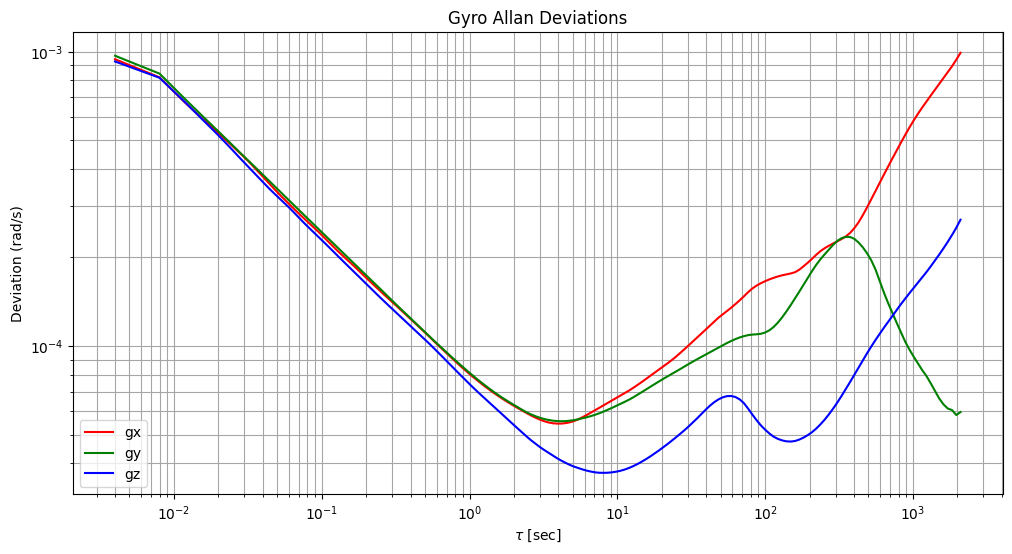

In [47]:
gfig,gaxis=plot_allan_gyro(gyro_taus, gyro_adevs)

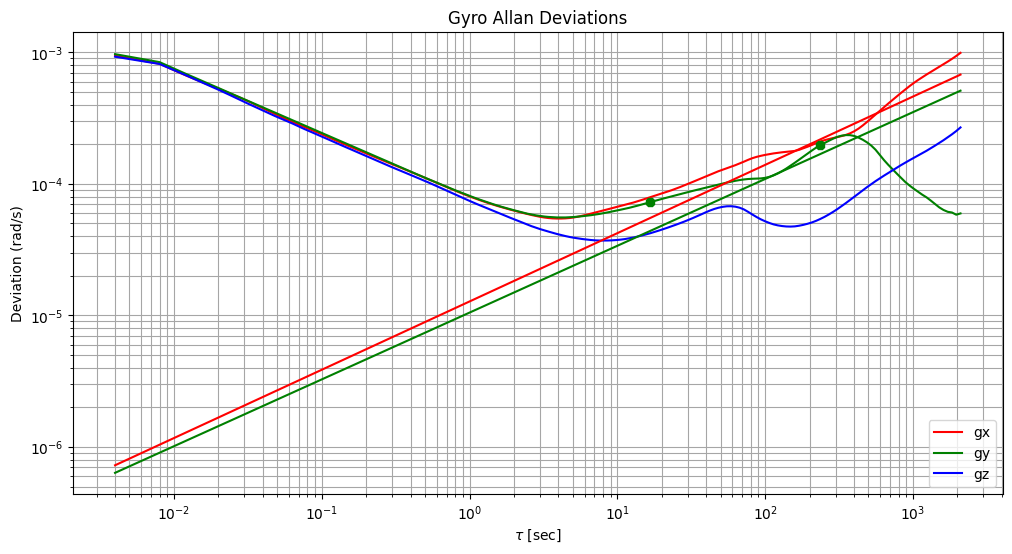

In [81]:
gaxis.plot(taux,rw_fit_x(taux),'r')
gaxis.plot(tauy,rw_fit_y(tauy),'g')
gaxis.plot(tauy[100],ady[100],'g8')
gaxis.plot(tauy[140],ady[140],'g8')

gfig
# the following doesn't work:
# gfig.show()
# plt.show()
# gaxis.show()
# print(len(tauy))


In [42]:
def noise_parameters_from_adev(tau_xyz,adev_xyz):
    # TODO: add custom parameters in case fit is unsuccessful
    # find angle random walk, intersection of random walk line fit (-0.5 slope)
    # at tau = 1
    # add curve fit to proper section of curve
    # that is, between  10^-1 < tau < 20 for the gx component for one of the OAK-D
    # Location for the other components (gy, gz) is likely (slightly) different
    # get the corresponding indexes (manual work, could do auto)
    taux,tauy,tauz = tau_xyz[0],tau_xyz[1],tau_xyz[2]
    adx,ady,adz = adev_xyz[0],adev_xyz[1],adev_xyz[2]
    idx_start = np.where(taux < 0.1)[0][-1]
    idx_end = np.where(taux > 20)[0][0]
    print(f'linear -0.5 slope for gx: = {idx_start,idx_end}')
    logtaux = np.log(taux[idx_start:idx_end])
    logadx = np.log(adx[idx_start:idx_end])
    # for gy
    idx_start = np.where(tauy < 0.05)[0][-1]
    idx_end = np.where(tauy > 10)[0][0]
    print(f'linear -0.5 slope for gy: = {idx_start,idx_end}')
    logtauy = np.log(tauy[idx_start:idx_end])
    logady = np.log(ady[idx_start:idx_end])
    # for gz
    idx_start = np.where(tauz < 0.06)[0][-1]
    idx_end = np.where(tauz > 10)[0][0]
    print(f'linear -0.5 slope for gz: = {idx_start,idx_end}')
    logtauz = np.log(tauz[idx_start:idx_end])
    logadz = np.log(adz[idx_start:idx_end])
    #####
    # below we do 2 different fits: one with fixed -0.5 slope, the other computes the slope (linear fit)
    # fix the slope for the linear fit
    #####
    UP_BOUND_SLOPE = -0.5
    LO_BOUND_SLOPE = -0.5001
    popt_cons, _ = curve_fit(fitfunc, logtaux,logadx, bounds=([LO_BOUND_SLOPE,-np.inf],
                                                              [UP_BOUND_SLOPE,np.inf]))
    print(f'popt_cons = {popt_cons}')
    # compute the slope
    coeffs_x = np.polyfit(logtaux,logadx, deg=1)
    coeffs_y = np.polyfit(logtauy,logady, deg=1)
    coeffs_z = np.polyfit(logtauz,logadz, deg=1)
    print(coeffs_x,coeffs_y,coeffs_z)
    poly_x = np.poly1d(coeffs_x)
    poly_y = np.poly1d(coeffs_y)
    poly_z = np.poly1d(coeffs_z)
    #yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
    #yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
    #yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
    # random walk fit
    rw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
    rw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
    rw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
    # -0.5 slope line fit to random walk
    fixpoly_x = np.poly1d(popt_cons)
    #fixpoly_y = np.poly1d(coeffs_y)
    #fixpoly_z = np.poly1d(coeffs_z)
    rw_fixfit_x = lambda taux: np.exp(fixpoly_x(np.log(taux)))
    #rw_fixfit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
    #rw_fixfit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
    
    # angle random walk
    # often noted N
    # unit rad/s/√Hz or rad/√s or °/√hr for a more palpable unit
    gyro_angle_randwalk_x = rw_fit_x(1)
    gyro_angle_randwalk_x_fixfit = rw_fixfit_x(1)
    gyro_angle_randwalk_y = rw_fit_y(1)
    gyro_angle_randwalk_z = rw_fit_z(1)
    gyro_angle_randwalk_xyz = np.array([gyro_angle_randwalk_x,gyro_angle_randwalk_y,gyro_angle_randwalk_z])
    gyro_angle_randwalk_avg = (gyro_angle_randwalk_x
                               + gyro_angle_randwalk_y
                               + gyro_angle_randwalk_z) / 3.0
    gyro_angle_randwalk_avg_dph = 60 * gyro_angle_randwalk_avg * RAD_2_DEG
    print((f'gyro_angle_randwalk_x: from linear fit '
          f'{gyro_angle_randwalk_x:.{PRECI}{TYPE}},'
          f'from -0.5 slope fit: {gyro_angle_randwalk_x_fixfit:.{PRECI}{TYPE}}'))
    print(f'gyro_angle_randwalk_y = {gyro_angle_randwalk_y:.{PRECI}{TYPE}}')
    print(f'gyro_angle_randwalk_z = {gyro_angle_randwalk_z:.{PRECI}{TYPE}}')
    print(f'Average gyro_angle_randwalk = '
          f'{gyro_angle_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/√s'
          f' or {gyro_angle_randwalk_avg_dph:.{PRECI:g}} °/√hr (deg/sqrt(hour))')
          #f' or {gyro_angle_randwalk_avg_dph:.{PRECI}{TYPE}} °/√hr (deg/sqrt(hour))')
    #print(f'Sqrt Average gyro_angle_randwalk \
        #= {np.sqrt(gyro_angle_randwalk_avg):.{PRECI}{TYPE}}')
    
    # get the rate random walk (unit: (rad/s)/√Hz
    # fit in the other direction
    # slop of 1
    
    idx_start = np.where(taux > 100)[0][0]
    idx_end = np.where(taux < 1000)[0][-1]
    print(f'linear fit slope for gx: = {idx_start,idx_end}')
    logtaux = np.log(taux[idx_start:idx_end])
    logadx = np.log(adx[idx_start:idx_end])
    # for gy
    idx_start = np.where(tauy > 100)[0][0]
    idx_end = np.where(tauy < 1000)[0][-1]
    if MEAS_FILENAME_NO_EXT == 'OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp':
        idx_end = np.where(tauy < 140)[0][-1]
    else:
        idx_end = np.where(tauy < 1000)[0][-1]
    print(f'linear fit slope for gy: = {idx_start,idx_end}')
    logtauy = np.log(tauy[idx_start:idx_end])
    logady = np.log(ady[idx_start:idx_end])
    # for gz
    idx_start = np.where(tauz > 100)[0][0]
    idx_end = np.where(tauz < 1000)[0][-1]
    print(f'linear fit slope for gz: = {idx_start,idx_end}')
    logtauz = np.log(tauz[idx_start:idx_end])
    logadz = np.log(adz[idx_start:idx_end])
    
    coeffs_x = np.polyfit(logtaux,logadx, deg=1)
    coeffs_y = np.polyfit(logtauy,logady, deg=1)
    coeffs_z = np.polyfit(logtauz,logadz, deg=1)
    print(coeffs_x,coeffs_y,coeffs_z)
    poly_x = np.poly1d(coeffs_x)
    poly_y = np.poly1d(coeffs_y)
    poly_z = np.poly1d(coeffs_z)
    #yfit = lambda x: poly_x(taux)
    rrw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
    rrw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
    rrw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
    #yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
    #yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
    #yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
    #################
    # Bias instability
    # not used in Kalibr 
    #################
    # compute derivative of Allan curve and intersect with line of slope 0
    
    deriv_x = np.gradient(adx,taux)
    deriv_y = np.gradient(ady,tauy)
    deriv_z = np.gradient(adz,tauz)
    local_min_x = np.argmin(np.abs(deriv_x))
    local_min_y = np.argmin(np.abs(deriv_y))
    local_min_z = np.argmin(np.abs(deriv_z))
    scale_fact = np.sqrt(2*np.log(2)/np.pi)
    bias_instab_x =adx[local_min_x] * scale_fact
    bias_instab_y =ady[local_min_y] * scale_fact
    bias_instab_z =adz[local_min_z] * scale_fact
    gyro_bias_instab_avg = (bias_instab_x + bias_instab_y + bias_instab_z)/3.0
    gyro_bias_instab_avg_dph = 3600 * gyro_bias_instab_avg * RAD_2_DEG
    print(f'local min: {np.argmin(np.abs(deriv_x))}, scale_fact = {scale_fact}')
    print(f'Bias instability in x: {bias_instab_x:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
    print(f'Bias instability in y: {bias_instab_y:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
    print(f'Bias instability in z: {bias_instab_z:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
    print(f'Average bias instability = '
        f'{gyro_bias_instab_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s '
        f'{gyro_bias_instab_avg_dph:.{PRECI}} deg/hr')
    bias_instab_xyz = np.array([bias_instab_x,bias_instab_y,bias_instab_z])
    #print(f'dev = {logadx(local_min[0])}')
    
    # find K, rate random walk unit (rad/s)*√Hz or (°/s)*√Hz
    # gyro "random walk" in Kalibr
    #, intersection of random walk line fit
    # at tau = 3
    # print(f'poly_z = {poly_z}')
    # print(f'rrw_fit_z(1)= {rrw_fit_z(1)}')
    gyro_rate_randwalk_x = rrw_fit_x(3)
    gyro_rate_randwalk_y = rrw_fit_y(3)
    gyro_rate_randwalk_z = rrw_fit_z(3)
    gyro_rate_randwalk_xyz = np.array([gyro_rate_randwalk_x,gyro_rate_randwalk_y,gyro_rate_randwalk_z])
    gyro_rate_randwalk_avg = (gyro_rate_randwalk_x + gyro_rate_randwalk_y + gyro_rate_randwalk_z)/3.0
    gyro_rate_randwalk_rms = np.sqrt((gyro_rate_randwalk_x*gyro_rate_randwalk_x 
                                      + gyro_rate_randwalk_y*gyro_rate_randwalk_y 
                                      + gyro_rate_randwalk_z*gyro_rate_randwalk_z))
    
    print(f'gyro_rate_randwalk_x = {gyro_rate_randwalk_x:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
    print(f'gyro_rate_randwalk_y = {gyro_rate_randwalk_y:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
    print(f'gyro_rate_randwalk_z = {gyro_rate_randwalk_z:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
    print(f'Average gyro_rate_randwalk = {gyro_rate_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
    print(f'RMS gyro_rate_randwalk (Kg)= {gyro_rate_randwalk_rms:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

    return bias_instab_xyz,gyro_rate_randwalk_xyz,gyro_angle_randwalk_xyz,rw_fit_x


In [48]:
gyro_taus = (taux,tauy,tauz)
gyro_adevs = (adx,ady,adz)
a,b,c,rwfit = noise_parameters_from_adev(gyro_taus,gyro_adevs)
print(a,b,c,rwfit)

linear -0.5 slope for gx: = (22, 103)
linear -0.5 slope for gy: = (11, 93)
linear -0.5 slope for gz: = (13, 93)
popt_cons = [-0.5        -9.15318946]
[-0.25001166 -9.22979593] [-0.37237718 -9.26209481] [-0.44321011 -9.44299241]
gyro_angle_randwalk_x: from linear fit 9.81e-05,from -0.5 slope fit: 1.06e-04
gyro_angle_randwalk_y = 9.50e-05
gyro_angle_randwalk_z = 7.92e-05
Average gyro_angle_randwalk = 9.08e-05 rad/√s or 0.31 °/√hr (deg/sqrt(hour))
linear fit slope for gx: = (128, 161)
linear fit slope for gy: = (128, 161)
linear fit slope for gz: = (128, 161)
[  0.51934709 -11.2690772 ] [ 0.04725438 -8.97059992] [  0.57909282 -12.86432237]
local min: 132, scale_fact = 0.6642824702679601
Bias instability in x: 1.16e-04rad/s
Bias instability in y: 3.87e-05rad/s
Bias instability in z: 3.15e-05rad/s
Average bias instability = 6.22e-05 rad/s 1.3e+01 deg/hr
gyro_rate_randwalk_x = 2.26e-05 rad/s/√s
gyro_rate_randwalk_y = 1.34e-04 rad/s/√s
gyro_rate_randwalk_z = 4.89e-06 rad/s/√s
Average gyro_rat

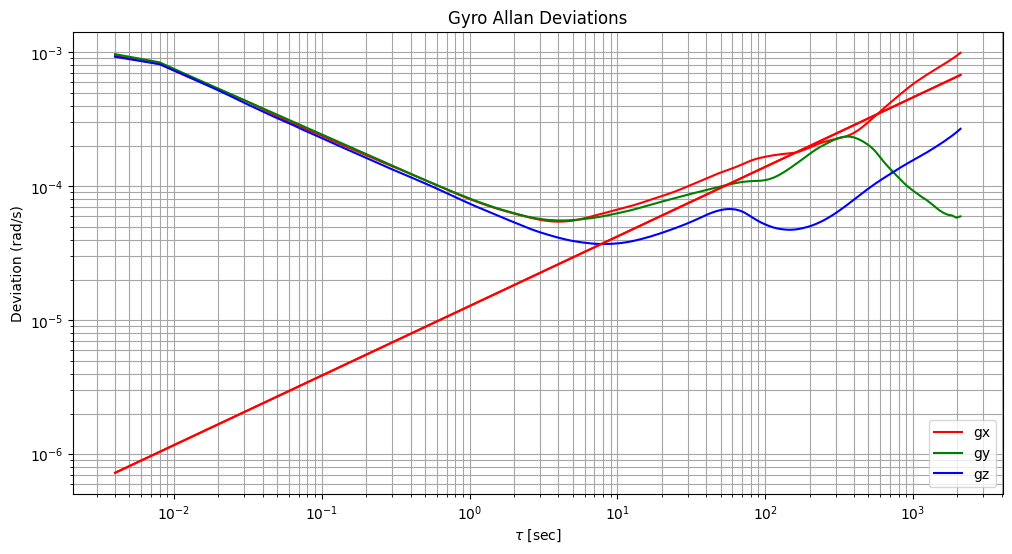

In [50]:
def add_noise_results_on_plot(afig,aaxis,taus,rw_fits):
    aaxis.plot(taus,rw_fits(taux),'r')
add_noise_results_on_plot(gfig,gaxis,taux,rw_fit_x)
gfig

linear -0.5 slope for gx: = (22, 103)
linear -0.5 slope for gy: = (11, 93)
linear -0.5 slope for gz: = (13, 93)
popt_cons = [-0.5        -9.15318946]
[-0.25001166 -9.22979593] [-0.37237718 -9.26209481] [-0.44321011 -9.44299241]
gyro_angle_randwalk_x: from linear fit 9.81e-05,from -0.5 slope fit: 1.06e-04
gyro_angle_randwalk_y = 9.50e-05
gyro_angle_randwalk_z = 7.92e-05
Average gyro_angle_randwalk = 9.08e-05 rad/√s or 0.31 °/√hr (deg/sqrt(hour))
linear fit slope for gx: = (128, 161)
linear fit slope for gy: = (128, 132)
linear fit slope for gz: = (128, 161)
[  0.51934709 -11.2690772 ] [  0.50803507 -11.46392961] [  0.57909282 -12.86432237]
local min: 132, scale_fact = 0.6642824702679601
Bias instability in x: 1.16e-04rad/s
Bias instability in y: 3.87e-05rad/s
Bias instability in z: 3.15e-05rad/s
Average bias instability = 6.22e-05 rad/s 1.3e+01 deg/hr
gyro_rate_randwalk_x = 2.26e-05 rad/s/√s
gyro_rate_randwalk_y = 1.84e-05 rad/s/√s
gyro_rate_randwalk_z = 4.89e-06 rad/s/√s
Average gyro_r

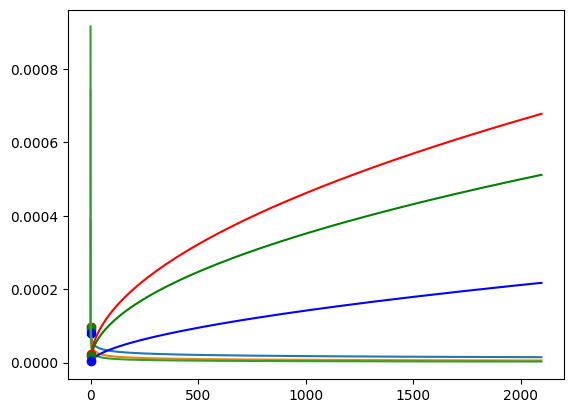

In [17]:
# find angle random walk, intersection of random walk line fit (-0.5 slope)
# at tau = 1
# add curve fit to proper section of curve
# that is, between  10^-1 < tau < 20 for the gx component for one of the OAK-D
# Location for the other components (gy, gz) is likely (slightly) different
# get the corresponding indexes (manual work, could do auto)
idx_start = np.where(taux < 0.1)[0][-1]
idx_end = np.where(taux > 20)[0][0]
print(f'linear -0.5 slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy < 0.05)[0][-1]
idx_end = np.where(tauy > 10)[0][0]
print(f'linear -0.5 slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz < 0.06)[0][-1]
idx_end = np.where(tauz > 10)[0][0]
print(f'linear -0.5 slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])
#####
# below we do 2 different fits: one with fixed -0.5 slope, the other computes the slope (linear fit)
# fix the slope for the linear fit
#####
UP_BOUND_SLOPE = -0.5
LO_BOUND_SLOPE = -0.5001
popt_cons, _ = curve_fit(fitfunc, logtaux,logadx, bounds=([LO_BOUND_SLOPE,-np.inf],
                                                          [UP_BOUND_SLOPE,np.inf]))
print(f'popt_cons = {popt_cons}')
# compute the slope
coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
# random walk fit
rw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
# -0.5 slope line fit to random walk
fixpoly_x = np.poly1d(popt_cons)
#fixpoly_y = np.poly1d(coeffs_y)
#fixpoly_z = np.poly1d(coeffs_z)
rw_fixfit_x = lambda taux: np.exp(fixpoly_x(np.log(taux)))
#rw_fixfit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
#rw_fixfit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))

# angle random walk
# often noted N
# unit rad/s/√Hz or rad/√s or °/√hr for a more palpable unit
gyro_angle_randwalk_x = rw_fit_x(1)
gyro_angle_randwalk_x_fixfit = rw_fixfit_x(1)
gyro_angle_randwalk_y = rw_fit_y(1)
gyro_angle_randwalk_z = rw_fit_z(1)
gyro_angle_randwalk_avg = (gyro_angle_randwalk_x
                           + gyro_angle_randwalk_y
                           + gyro_angle_randwalk_z) / 3.0
gyro_angle_randwalk_avg_dph = 60 * gyro_angle_randwalk_avg * RAD_2_DEG
print((f'gyro_angle_randwalk_x: from linear fit '
      f'{gyro_angle_randwalk_x:.{PRECI}{TYPE}},'
      f'from -0.5 slope fit: {gyro_angle_randwalk_x_fixfit:.{PRECI}{TYPE}}'))
print(f'gyro_angle_randwalk_y = {gyro_angle_randwalk_y:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_z = {gyro_angle_randwalk_z:.{PRECI}{TYPE}}')
print(f'Average gyro_angle_randwalk = '
      f'{gyro_angle_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/√s'
      f' or {gyro_angle_randwalk_avg_dph:.{PRECI:g}} °/√hr (deg/sqrt(hour))')
      #f' or {gyro_angle_randwalk_avg_dph:.{PRECI}{TYPE}} °/√hr (deg/sqrt(hour))')
#print(f'Sqrt Average gyro_angle_randwalk \
    #= {np.sqrt(gyro_angle_randwalk_avg):.{PRECI}{TYPE}}')
plt.plot(1,gyro_angle_randwalk_x,'r8')
plt.plot(1,gyro_angle_randwalk_y,'g8')
plt.plot(1,gyro_angle_randwalk_z,'b8')
plt.plot(taux,rw_fit_x(taux))
plt.plot(tauy,rw_fit_y(tauy))
plt.plot(tauz,rw_fit_z(tauz))

# get the rate random walk (unit: (rad/s)/√Hz
# fit in the other direction
# slop of 1

idx_start = np.where(taux > 100)[0][0]
idx_end = np.where(taux < 1000)[0][-1]
print(f'linear fit slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy > 100)[0][0]
idx_end = np.where(tauy < 1000)[0][-1]
if CSV_FILENAME == HOME+'/Data/Drones/IMU/OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp.csv':
    idx_end = np.where(tauy < 140)[0][-1]
else:
    idx_end = np.where(tauy < 1000)[0][-1]
print(f'linear fit slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz > 100)[0][0]
idx_end = np.where(tauz < 1000)[0][-1]
print(f'linear fit slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])

coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit = lambda x: poly_x(taux)
rrw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rrw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rrw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
plt.plot(taux,rrw_fit_x(taux), 'r')
plt.plot(tauy,rrw_fit_y(tauy), 'g')
plt.plot(tauz,rrw_fit_z(tauz), 'b')
#plt.plot(tauz,yfit_z(tauz))
#################
# Bias instability
# not used in Kalibr 
#################
# compute derivative of Allan curve and intersect with line of slope 0

deriv_x = np.gradient(adx,taux)
deriv_y = np.gradient(ady,tauy)
deriv_z = np.gradient(adz,tauz)
local_min_x = np.argmin(np.abs(deriv_x))
local_min_y = np.argmin(np.abs(deriv_y))
local_min_z = np.argmin(np.abs(deriv_z))
scale_fact = np.sqrt(2*np.log(2)/np.pi)
bias_instab_x =adx[local_min_x] * scale_fact
bias_instab_y =ady[local_min_y] * scale_fact
bias_instab_z =adz[local_min_z] * scale_fact
gyro_bias_instab_avg = (bias_instab_x + bias_instab_y + bias_instab_z)/3.0
gyro_bias_instab_avg_dph = 3600 * gyro_bias_instab_avg * RAD_2_DEG
print(f'local min: {np.argmin(np.abs(deriv_x))}, scale_fact = {scale_fact}')
print(f'Bias instability in x: {bias_instab_x:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Bias instability in y: {bias_instab_y:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Bias instability in z: {bias_instab_z:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Average bias instability = '
    f'{gyro_bias_instab_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s '
    f'{gyro_bias_instab_avg_dph:.{PRECI}} deg/hr')
#print(f'dev = {logadx(local_min[0])}')

# find K, rate random walk unit (rad/s)*√Hz or (°/s)*√Hz
# gyro "random walk" in Kalibr
#, intersection of random walk line fit
# at tau = 3
# print(f'poly_z = {poly_z}')
# print(f'rrw_fit_z(1)= {rrw_fit_z(1)}')
gyro_rate_randwalk_x = rrw_fit_x(3)
gyro_rate_randwalk_y = rrw_fit_y(3)
gyro_rate_randwalk_z = rrw_fit_z(3)
gyro_rate_randwalk_avg = (gyro_rate_randwalk_x + gyro_rate_randwalk_y + gyro_rate_randwalk_z)/3.0
gyro_rate_randwalk_rms = np.sqrt((gyro_rate_randwalk_x*gyro_rate_randwalk_x 
                                  + gyro_rate_randwalk_y*gyro_rate_randwalk_y 
                                  + gyro_rate_randwalk_z*gyro_rate_randwalk_z))

print(f'gyro_rate_randwalk_x = {gyro_rate_randwalk_x:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_y = {gyro_rate_randwalk_y:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_z = {gyro_rate_randwalk_z:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'Average gyro_rate_randwalk = {gyro_rate_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'RMS gyro_rate_randwalk (Kg)= {gyro_rate_randwalk_rms:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

plt.plot(3,gyro_rate_randwalk_x,'ro')
plt.plot(3,gyro_rate_randwalk_y,'go')
plt.plot(3,gyro_rate_randwalk_z,'bo')
plt.show()


In [105]:
# Calculate velocity
velx = np.cumsum(accx) * TS  # deg or rad depending on ANGLE_UNIT_FOR_NOISE
vely = np.cumsum(accy) * TS
velz = np.cumsum(accz) * TS

# Compute Allan deviations
Mnb = 200 # for noise analysis
(taux, adx) = AllanDeviation(velx, FS, maxNumM=Mnb)
(tauy, ady) = AllanDeviation(vely, FS, maxNumM=Mnb)
(tauz, adz) = AllanDeviation(velz, FS, maxNumM=Mnb)


## Accelerometer

In [106]:
tauy[-10]

1155.996

linear -0.5 slope for gx: = (22, 103)
linear -0.5 slope for gy: = (11, 93)
linear -0.5 slope for gz: = (13, 93)
popt_cons = [-0.5        -6.84733456]
[-0.32766714 -6.90014427] [-0.33467765 -6.79970911] [-0.38725847 -6.83083638]
accel_veloci_randwalk_x: from linear fit 1.01e-03,from -0.5 slope fit: 1.06e-03
accel_veloci_randwalk_y = 1.11e-03
accel_veloci_randwalk_z = 1.08e-03
Average accel_veloci_randwalk = 1.07e-03 m/s/√s or 0.064 m/s/√hr (m/s/sqrt(hour))
linear fit slope for gx: = (128, 161)
linear fit slope for gy: = (-10, -1)
linear fit slope for gz: = (-10, -1)
[ 0.47006453 -9.17447306] [  0.55220432 -10.64189576] [  0.79220455 -12.98264235]
local min: 96, scale_fact = 0.6642824702679601
Bias instability in x: 3.42e-04m/s²
Bias instability in y: 7.46e-04m/s²
Bias instability in z: 5.05e-04m/s²
Average bias instability = 5.31e-04 m/s² 1.9 deg/hr
acceleration_randwalk_x = 1.74e-04 m/s²/√s
acceleration_randwalk_y = 4.38e-05 m/s²/√s
acceleration_randwalk_z = 5.49e-06 m/s²/√s
Average ac

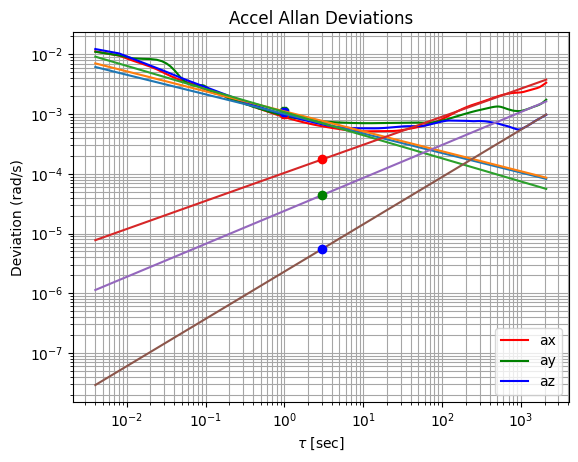

In [107]:
# Plot data on log-scale
plt.figure()
plt.title('Accel Allan Deviations')
plt.plot(taux, adx, 'r', label='ax')
plt.plot(tauy, ady, 'g',label='ay')
plt.plot(tauz, adz, 'b',label='az')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel(f'Deviation ({ANGLE_UNIT_FOR_NOISE}/s)')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.show()
# find angle random walk, intersection of random walk line fit (-0.5 slope)
# at tau = 1
# add curve fit to proper section of curve
# that is, between  10^-1 < tau < 20 for the gx component for one of the OAK-D
# Location for the other components (gy, gz) is likely (slightly) different
# get the corresponding indexes (manual work, could do auto)
idx_start = np.where(taux < 0.1)[0][-1]
idx_end = np.where(taux > 20)[0][0]
print(f'linear -0.5 slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy < 0.05)[0][-1]
idx_end = np.where(tauy > 10)[0][0]
print(f'linear -0.5 slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz < 0.06)[0][-1]
idx_end = np.where(tauz > 10)[0][0]
print(f'linear -0.5 slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])
#####
# below we do 2 different fits: one with fixed -0.5 slope, the other computes the slope (linear fit)
# fix the slope for the linear fit
#####
UP_BOUND_SLOPE = -0.5
LO_BOUND_SLOPE = -0.5001
popt_cons, _ = curve_fit(fitfunc, logtaux,logadx, bounds=([LO_BOUND_SLOPE,-np.inf],
                                                          [UP_BOUND_SLOPE,np.inf]))
print(f'popt_cons = {popt_cons}')
# compute the slope
coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
# random walk fit
rw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
# -0.5 slope line fit to random walk
fixpoly_x = np.poly1d(popt_cons)
#fixpoly_y = np.poly1d(coeffs_y)
#fixpoly_z = np.poly1d(coeffs_z)
rw_fixfit_x = lambda taux: np.exp(fixpoly_x(np.log(taux)))
#rw_fixfit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
#rw_fixfit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))

# velocity random walk
# noted Na or σa, 
# unit m/s²/√Hz or (m/s)/√s or (m/s)√Hz, or (m/s)/√hr for a more palpable unit
accel_veloci_randwalk_x = rw_fit_x(1)
accel_veloci_randwalk_x_fixfit = rw_fixfit_x(1)
accel_veloci_randwalk_y = rw_fit_y(1)
accel_veloci_randwalk_z = rw_fit_z(1)
accel_veloci_randwalk_avg = (accel_veloci_randwalk_x
                           + accel_veloci_randwalk_y
                           + accel_veloci_randwalk_z) / 3.0
accel_veloci_randwalk_avg_dph = 60 * accel_veloci_randwalk_avg
print((f'accel_veloci_randwalk_x: from linear fit '
      f'{accel_veloci_randwalk_x:.{PRECI}{TYPE}},'
      f'from -0.5 slope fit: {accel_veloci_randwalk_x_fixfit:.{PRECI}{TYPE}}'))
print(f'accel_veloci_randwalk_y = {accel_veloci_randwalk_y:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_z = {accel_veloci_randwalk_z:.{PRECI}{TYPE}}')
print(f'Average accel_veloci_randwalk = '
      f'{accel_veloci_randwalk_avg:.{PRECI}{TYPE}} {VELOCITY_UNIT_FOR_NOISE}/√s'
      f' or {accel_veloci_randwalk_avg_dph:.{PRECI:g}} {VELOCITY_UNIT_FOR_NOISE}/√hr (m/s/sqrt(hour))')
      #f' or {accel_veloci_randwalk_avg_dph:.{PRECI}{TYPE}} °/√hr (deg/sqrt(hour))')
#print(f'Sqrt Average accel_veloci_randwalk \
    #= {np.sqrt(accel_veloci_randwalk_avg):.{PRECI}{TYPE}}')
plt.plot(1,accel_veloci_randwalk_x,'r8')
plt.plot(1,accel_veloci_randwalk_y,'g8')
plt.plot(1,accel_veloci_randwalk_z,'b8')
plt.plot(taux,rw_fit_x(taux))
plt.plot(tauy,rw_fit_y(tauy))
plt.plot(tauz,rw_fit_z(tauz))

# get the rate random walk (unit: (rad/s)/√Hz
# fit in the other direction
# slop 1
idx_start = np.where(taux > 100)[0][0]
idx_end = np.where(taux < 1000)[0][-1]
print(f'linear fit slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
#custom location for the fit needed if ADEV is unusual
if CSV_FILENAME == HOME+'/Data/Drones/IMU/OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp.csv':
    idx_start = -10 #tauy[-10] #np.where(tauy > 100)[0][0]
    idx_end = -1 #tauy [-1] #np.where(tauy < 120)[0][-1]
else:
    idx_start = np.where(tauy > 100)[0][0]
    idx_end = np.where(tauy < 1000)[0][-1]

print(f'linear fit slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
if CSV_FILENAME == HOME+'/Data/Drones/IMU/OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp.csv':
    idx_start = -10 #tauy[-10] #np.where(tauy > 100)[0][0]
    idx_end = -1 #tauy [-1] #np.where(tauy < 120)[0][-1]
else:
    idx_start = np.where(tauy > 100)[0][0]
    idx_end = np.where(tauy < 1000)[0][-1]

print(f'linear fit slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])

coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit = lambda x: poly_x(taux)
rrw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rrw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rrw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
plt.plot(taux,rrw_fit_x(taux))
plt.plot(tauy,rrw_fit_y(tauy))
plt.plot(tauz,rrw_fit_z(tauz))
#plt.plot(tauz,yfit_z(tauz))
#################
# Bias instability, Ba
# not used in Kalibr
#################
# compute derivative of Allan curve and intersect with line of slope 0

deriv_x = np.gradient(adx,taux)
deriv_y = np.gradient(ady,tauy)
deriv_z = np.gradient(adz,tauz)
local_min_x = np.argmin(np.abs(deriv_x))
local_min_y = np.argmin(np.abs(deriv_y))
local_min_z = np.argmin(np.abs(deriv_z))
scale_fact = np.sqrt(2*np.log(2)/np.pi)
bias_instab_x =adx[local_min_x] * scale_fact
bias_instab_y =ady[local_min_y] * scale_fact
bias_instab_z =adz[local_min_z] * scale_fact
accel_bias_instab_avg = (bias_instab_x + bias_instab_y + bias_instab_z)/3.0
accel_bias_instab_avg_dph = 3600 * accel_bias_instab_avg
print(f'local min: {np.argmin(np.abs(deriv_x))}, scale_fact = {scale_fact}')
print(f'Bias instability in x: {bias_instab_x:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Bias instability in y: {bias_instab_y:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Bias instability in z: {bias_instab_z:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Average bias instability = '
    f'{accel_bias_instab_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE} '
    f'{accel_bias_instab_avg_dph:.{PRECI}} deg/hr')

# find acceleration random walk unit (m/s²)*√Hz or g*√Hz or (m/s²)/√s or g/√s
# usually noted K
#, intersection of random walk line fit
# at tau = 3
# print(f'poly_z = {poly_z}')
# print(f'rrw_fit_z(1)= {rrw_fit_z(1)}')
acceleration_randwalk_x = rrw_fit_x(3)
acceleration_randwalk_y = rrw_fit_y(3)
acceleration_randwalk_z = rrw_fit_z(3)
acceleration_randwalk_avg = (acceleration_randwalk_x + acceleration_randwalk_y + acceleration_randwalk_z)/3.0
print(f'acceleration_randwalk_x = {acceleration_randwalk_x:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_y = {acceleration_randwalk_y:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_z = {acceleration_randwalk_z:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'Average acceleration_randwalk = {acceleration_randwalk_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
plt.plot(3,acceleration_randwalk_x,'ro')
plt.plot(3,acceleration_randwalk_y,'go')
plt.plot(3,acceleration_randwalk_z,'bo')
plt.show()


## Summary of results

In [109]:
# angle random walk
# often noted N
# unit rad/s/√Hz or rad/√s or °/√hr for a more palpable unit
print(f'accel_veloci_randwalk_x: {accel_veloci_randwalk_x:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_y = {accel_veloci_randwalk_y:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_z = {accel_veloci_randwalk_z:.{PRECI}{TYPE}}')

print(f'acceleration_randwalk_x = {acceleration_randwalk_x:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_y = {acceleration_randwalk_y:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_z = {acceleration_randwalk_z:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')


print(f'gyro_angle_randwalk_x: {gyro_angle_randwalk_x:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_y = {gyro_angle_randwalk_y:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_z = {gyro_angle_randwalk_z:.{PRECI}{TYPE}}')
# K, rate random walk unit (rad/s)*√Hz or (°/s)*√Hz
# gyro "random walk" in Kalibr
print(f'gyro_rate_randwalk_x = {gyro_rate_randwalk_x:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_y = {gyro_rate_randwalk_y:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_z = {gyro_rate_randwalk_z:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

# For VINS, Kalibr, EuRoc....
print(f'\nfor Kalibr: \n')

print(f'Average accel_veloci_randwalk(Na, σba) or noise density = '
      f'{accel_veloci_randwalk_avg:.{PRECI}{TYPE}} {VELOCITY_UNIT_FOR_NOISE}/√s'
      f' or {accel_veloci_randwalk_avg_dph:.{PRECI:g}} {VELOCITY_UNIT_FOR_NOISE}/√hr (m/s/sqrt(hour))')
print(f'Average acceleration_randwalk (Ka, σa)= {acceleration_randwalk_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')

print(f'Average gyro_angle_randwalk (Ng, σbg) or noise density = '
      f'{gyro_angle_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/√s'
      f' or {gyro_angle_randwalk_avg_dph:.{PRECI:g}} °/√hr (deg/sqrt(hour))')
print(f'Average gyro_rate_randwalk  (Kg, σg) = {gyro_rate_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

print(f'\nfor VINS (15x the above results): \n')
acc_n = 15 * accel_veloci_randwalk_avg
gyr_n = 15 * gyro_angle_randwalk_avg
acc_w = 15 * acceleration_randwalk_avg
gyr_w = 15 * gyro_rate_randwalk_avg
print(f'acc_n: {acc_n:.4f}')
print(f'gyr_n: {gyr_n:.4f}')
print(f'acc_w: {acc_w:.4f}')
print(f'gyr_w: {gyr_w:.4f}')

accel_veloci_randwalk_x: 1.01e-03
accel_veloci_randwalk_y = 1.11e-03
accel_veloci_randwalk_z = 1.08e-03
acceleration_randwalk_x = 1.74e-04 m/s²/√s
acceleration_randwalk_y = 4.38e-05 m/s²/√s
acceleration_randwalk_z = 5.49e-06 m/s²/√s
gyro_angle_randwalk_x: 9.81e-05
gyro_angle_randwalk_y = 9.50e-05
gyro_angle_randwalk_z = 7.92e-05
gyro_rate_randwalk_x = 2.26e-05 rad/s/√s
gyro_rate_randwalk_y = 1.84e-05 rad/s/√s
gyro_rate_randwalk_z = 4.89e-06 rad/s/√s

for Kalibr: 

Average accel_veloci_randwalk(Na, σba) or noise density = 1.07e-03 m/s/√s or 0.064 m/s/√hr (m/s/sqrt(hour))
Average acceleration_randwalk (Ka, σa)= 7.43e-05 m/s²/√s
Average gyro_angle_randwalk (Ng, σbg) or noise density = 9.08e-05 rad/√s or 0.31 °/√hr (deg/sqrt(hour))
Average gyro_rate_randwalk  (Kg, σg) = 1.53e-05 rad/s/√s

for VINS (15x the above results): 

acc_n: 0.0160
gyr_n: 0.0014
acc_w: 0.0011
gyr_w: 0.0002
